### Semantic Shift in Italian: A Computational Study
by Gaudenzia Genoni  
       ***  
Computational Linguistics Course  
Professor Raffaella Bernardi  
University of Trento

### Libraries

In [2]:
import os
import gzip
import shutil
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [3]:
# This cell is for Google Colab users
!pip install spacy
!python -m spacy download it_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 71.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
nlp = spacy.load("it_core_news_sm")

### The data

In [368]:
os.makedirs('google_5gram', exist_ok=True)

# URL for Google Ngram data
base_url = "http://storage.googleapis.com/books/ngrams/books/"

# Italian dataset file for words starting with "ac"
dataset = "googlebooks-ita-all-5gram-20120701-ac.gz"

os.system(f"wget {base_url}{dataset} -P google_5gram")

0

In [369]:
# Extract the downloaded .gz file
file_path = f"google_5gram/{dataset}"
extracted_file_path = file_path.replace('.gz', '')
with gzip.open(file_path, 'rb') as f_in:
    with open(extracted_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [370]:
extracted_file_path

'google_5gram/googlebooks-ita-all-5gram-20120701-ac'

In [390]:
data = pd.read_csv(extracted_file_path, sep='\t', header=None, names=['ngram', 'year', 'match_count', 'volume_count'])

# Filter for two specific periods: 1900-1959 and 1980-1999
data = data[((data['year'] >= 1900) & (data['year'] < 1960)) | ((data['year'] >= 1980) & (data['year'] < 2000))]

print(data.shape)


(1260736, 4)


In [391]:
data

,ngram,year,match_count,volume_count
16,ACCADEMIA_NOUN DI_ADP ARCHEOLOGIA_NOUN LETTERE...,1900,1,1
17,ACCADEMIA_NOUN DI_ADP ARCHEOLOGIA_NOUN LETTERE...,1902,1,1
18,ACCADEMIA_NOUN DI_ADP ARCHEOLOGIA_NOUN LETTERE...,1903,1,1
19,ACCADEMIA_NOUN DI_ADP ARCHEOLOGIA_NOUN LETTERE...,1905,1,1
20,ACCADEMIA_NOUN DI_ADP ARCHEOLOGIA_NOUN LETTERE...,1911,1,1
...,...,...,...,...
2584923,"actuositatem_NOUN ,_. n_NOUN ._. _END_",1994,4,1
2584924,"actuositatem_NOUN ,_. n_NOUN ._. _END_",1995,2,1
2584925,"actuositatem_NOUN ,_. n_NOUN ._. _END_",1996,1,1
2584926,"actuositatem_NOUN ,_. n_NOUN ._. _END_",1998,4,3


In [372]:
# This temp dataset is used for a preliminary quantitative inspection on the data
temp = data

In [373]:
temp['period'] = temp['year'].apply(lambda x: '1900-1959' if 1900 <= x < 1960 else '1980-1999' if 1980 <= x < 2000 else None)


In [374]:
temp[temp.period == '1900-1959'] .count()

,0
ngram,667841
year,667841
match_count,667841
volume_count,667841
period,667841


In [375]:
temp[temp.period == '1980-1999'] .count()

,0
ngram,592895
year,592895
match_count,592895
volume_count,592895
period,592895


### Data Preparation and Preprocessing 

In [ ]:
# Remove grammatical tags from each word in the 5-gram
data['ngram'] = data['ngram'].str.replace(r'_[A-Z]+', '', regex=True)

# Ensure the 5-grams contain only alphabetic characters
data = data[data['ngram'].str.replace(' ', '').str.isalpha()]

# Lowercase all n-grams
data['ngram'] = data['ngram'].str.lower()

# Remove stopwords
nlp = spacy.load("it_core_news_sm")
stop_words = set(nlp.Defaults.stop_words)

def remove_stopwords(ngram):
    words = ngram.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words) if filtered_words else None

data['ngram'] = data['ngram'].apply(remove_stopwords)

# Drop rows where the n-gram is empty
data = data.dropna(subset=['ngram'])

# Filter out rows where the ngram has been reduced to a single word
data = data[data['ngram'].str.split().apply(len) > 1]

# Add "period" column
data['period'] = data['year'].apply(lambda x: '1900-1959' if 1900 <= x < 1960 else '1980-1999' if 1980 <= x < 2000 else None)


In [436]:
print(data.shape)
data[5030:5040]

(459456, 5)


,ngram,year,match_count,volume_count,period
28573,accettare principio,1939,1,1,1900-1959
28574,accettare principio,1943,1,1,1900-1959
28575,accettare principio,1948,1,1,1900-1959
28576,accettare principio,1949,1,1,1900-1959
28577,accettare principio,1950,2,2,1900-1959
28578,accettare principio,1953,2,2,1900-1959
28579,accettare principio,1955,3,3,1900-1959
28580,accettare principio,1957,3,3,1900-1959
28581,accettare principio,1958,1,1,1900-1959
28597,accettare principio,1980,3,3,1980-1999


In [394]:
# Group by period and word, and sum the match_count and volume_count
aggregated = data.groupby(['period', 'ngram'], as_index=False)[['match_count', 'volume_count']].sum()

# Filter out rows where the ngram has been reduced to a single word
#aggregated = aggregated[aggregated['ngram'].str.split().apply(len) > 1]

print(aggregated.shape)


(16999, 4)


In [397]:
# Lemmatization

def lemmatize_ngram(ngram):
    doc = nlp(ngram)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

aggregated_data=aggregated

# Apply lemmatization to the ngrams
aggregated_data['lemmatized_ngram'] = aggregated_data['ngram'].apply(lemmatize_ngram)

# Group by period and lemmatized_ngram, and sum match_count and volume_count
aggregated_data = aggregated_data.groupby(['period', 'lemmatized_ngram'], as_index=False)[['match_count', 'volume_count']].sum()


In [427]:
print(aggregated_data.shape)

(15004, 4)


In [432]:
aggregated_data[1110:1120]

,period,lemmatized_ngram,match_count,volume_count
1110,1900-1959,accento cadere penultima sillaba,10,10
1111,1900-1959,accento cadere terzultimo sillaba,2,2
1112,1900-1959,accento carattere,6,6
1113,1900-1959,accento dolore,50,50
1114,1900-1959,accento esso,8,8
1115,1900-1959,accento funzione,4,4
1116,1900-1959,accento il,24,24
1117,1900-1959,accento individuale,2,2
1118,1900-1959,accento necessità,148,148
1119,1900-1959,accento pone,14,14


In [438]:
print(aggregated_data['period'].unique())

['1900-1959' '1980-1999']


In [437]:
print(aggregated_data[aggregated_data.period == "1900-1959"].match_count.mean())
print(aggregated_data[aggregated_data.period == "1900-1959"].match_count.min())
max_value_1900_1959 = aggregated_data[aggregated_data.period == "1900-1959"].match_count.max()
print(max_value_1900_1959)

aggregated_data[aggregated_data.match_count == max_value_1900_1959]

75.06360967426255
1
23174


,period,lemmatized_ngram,match_count,volume_count
359,1900-1959,accademia scienza torino,23174,10804


In [400]:
print(aggregated_data[aggregated_data.period == "1980-1999"].match_count.mean())
print(aggregated_data[aggregated_data.period == "1980-1999"].match_count.min())
max_value_1980_1999 = aggregated_data[aggregated_data.period == "1980-1999"].match_count.max()
print(max_value_1980_1999)

aggregated_data[aggregated_data.match_count == max_value_1980_1999]

85.6350783339702
1
12079


,period,lemmatized_ngram,match_count,volume_count
7361,1980-1999,accademia bello arte,12079,7474


In [401]:
temp = aggregated_data

In [402]:
temp.groupby('period')['match_count'].mean().reset_index()

,period,match_count
0,1900-1959,75.063610
1,1980-1999,85.635078


In [403]:
temp.groupby('period')['match_count'].quantile(0.75).reset_index()

,period,match_count
0,1900-1959,62.0
1,1980-1999,76.0


In [ ]:
# Group by period and calculate the 75th quantile for match_count in each period
quantile_thresholds = temp.groupby('period')['match_count'].quantile(0.75).reset_index()
quantile_thresholds.rename(columns={'match_count': 'quantile_75'}, inplace=True)

# Merge the quantile thresholds back into the original data
temp = temp.merge(quantile_thresholds, on='period', how='left')

# Filter the data to keep only words that have match_count >= the 75th quantile for their period
filtered_data = temp[temp['match_count'] >= temp['quantile_75']]

# Drop the quantile column
filtered_data = filtered_data.drop(columns=['quantile_75'])

# Reset the index of the filtered dataset
filtered_data = filtered_data.reset_index(drop=True)

#print(filtered_data.shape)

In [441]:
filtered_data[1000:1010]


,period,lemmatized_ngram,match_count,volume_count
1000,1900-1959,accordo organizzazione internazionale,150,130
1001,1900-1959,accordo organizzazione sindacale,184,178
1002,1900-1959,accordo osservare,358,352
1003,1900-1959,accordo osservazione,759,701
1004,1900-1959,accordo osservazione fare,118,114
1005,1900-1959,accordo ottenere,468,448
1006,1900-1959,accordo paese,62,58
1007,1900-1959,accordo papa,354,320
1008,1900-1959,accordo parte,2618,2452
1009,1900-1959,accordo parte contraente,178,170


In [405]:
filtered_data['period'].unique()

array(['1900-1959', '1980-1999'], dtype=object)

In [ ]:
unique_words = filtered_data['lemmatized_ngram'].nunique()
unique_periods = filtered_data['period'].nunique()
#print(f"Unique words: {unique_words}, Unique periods: {unique_periods}")

In [410]:
print(filtered_data[filtered_data['period'] == '1900-1959'].count())
filtered_data[filtered_data['period'] == '1900-1959'].match_count.sum()

period              1815
lemmatized_ngram    1815
match_count         1815
volume_count        1815
dtype: int64


413325

In [411]:
print(filtered_data[filtered_data['period'] == '1980-1999'].count())
filtered_data[filtered_data['period'] == '1980-1999'].match_count.sum()

period              1974
lemmatized_ngram    1974
match_count         1974
volume_count        1974
dtype: int64


497710

In [442]:
# Save the data
filtered_data.to_csv('filtered_ita_5gram.csv', index=False)
print("Processed data saved to 'filtered_ita_5gram.csv'")

Processed data saved to 'filtered_ita_5gram.csv'


### Embedding Training and Alignment

In [ ]:
# Create tokenized datasets for each period, weighted by match_count
corpus = {}
for period in filtered_data['period'].unique():
    period_data = filtered_data[filtered_data['period'] == period]
    # Expand n-grams based on their match_count
    weighted_ngrams = [
        ngram.split() for ngram, count in zip(period_data['lemmatized_ngram'], period_data['match_count'])
        for _ in range(int(count))
    ]
    corpus[period] = weighted_ngrams

In [445]:
print(f"Sample from 1900-1959: {corpus['1980-1999'][-1:]}")

Sample from 1900-1959: [['acuto', 'spirito', 'osservazione']]


In [409]:
# Train Word2Vec models for each period
models = {}
for period, sentences in corpus.items():
    print(f"Training SGNS model for period: {period}")
    models[period] = Word2Vec(
        sentences,              
        vector_size=300,        # Dimensionality of the embedding space
        window=3,               # Context window size (3 words before and after the target)
        min_count=1,            
        sg=1,                   
        negative=5,             # Number of negative samples per positive pair
        epochs=10               
    )
    models[period].save(f"sgns_{period}.model") 


Training SGNS model for period: 1900-1959
Training SGNS model for period: 1980-1999


In [412]:
# Extract common vocabulary
vocab = set(models['1900-1959'].wv.key_to_index.keys()) & set(models['1980-1999'].wv.key_to_index.keys())
print(len(vocab))

932


In [413]:
vocab

{'Absolvitur',
 'Academy',
 'Accorge',
 'Belles',
 'Berlino',
 'Bretagna',
 'Camera',
 'Cassazione',
 'Cecilia',
 'Como',
 'Costituzione',
 'Fiume',
 'Francia',
 'Germania',
 'Gioenia',
 'Gran',
 'Génois',
 'Italia',
 'Jugoslavia',
 'Londra',
 'Luca',
 'Milano',
 'Misura',
 'Morales',
 'Parigi',
 'Paris',
 'Re',
 'Roma',
 'Russia',
 'San',
 'Santa',
 'Sede',
 'Terra',
 'Uniti',
 'Venezia',
 'Vienna',
 'Woods',
 'ac',
 'academia',
 'academy',
 'académia',
 'accademia',
 'accademiare',
 'accademice',
 'accademio',
 'accadere',
 'accaduto',
 'accanto',
 'accantonare',
 'accatastare',
 'accedere',
 'acceleramento',
 'accelerare',
 'accelerazione',
 'accendere',
 'accenna',
 'accennare',
 'accenno',
 'accenrra',
 'accensione',
 'accento',
 'accentramento',
 'accentrare',
 'accentuare',
 'accentuazione',
 'acceptation',
 'accertamengere',
 'accertamento',
 'accertare',
 'accertarire',
 'accertato',
 'accerto',
 'accese',
 'accessibile',
 'accessione',
 'accesso',
 'accessoria',
 'accessorio'

In [414]:
# Create matrices for alignment
matrix_1900_1959 = np.array([models['1900-1959'].wv[word] for word in vocab])
matrix_1980_1999 = np.array([models['1980-1999'].wv[word] for word in vocab])

# Align the 1980-1999 embeddings to 1900-1959
R, _ = orthogonal_procrustes(matrix_1900_1959, matrix_1980_1999)
aligned_matrix_1980_1999 = matrix_1980_1999 @ R


In [ ]:
# Normalize the matrices row-wise (each vector corresponds to a row)
matrix_1800_1850_normalized = normalize(matrix_1900_1959, axis=1)
aligned_matrix_1950_1999_normalized = normalize(aligned_matrix_1980_1999, axis=1)

# Compute semantic displacement
displacement = {
    word: 1 - max(-1, min(1, cosine_similarity(
        [matrix_1800_1850_normalized[i]],
        [aligned_matrix_1950_1999_normalized[i]]
    )[0][0]))
    for i, word in enumerate(vocab)
}


# Sort displacement scores
sorted_displacement = sorted(displacement.items(), key=lambda x: x[1], reverse=True)

In [446]:
print("Most changed words:", sorted_displacement[:3])
print("Least changed words:", sorted_displacement[-3:])

Most changed words: [('acuto', 1.1737706810235977), ('dominante', 1.1458855271339417), ('accenno', 1.144735887646675)]
Least changed words: [('padre', 0.8486786484718323), ('donna', 0.8427019417285919), ('socio', 0.8352215588092804)]


### Visualization and Evaluation of Semantic Change

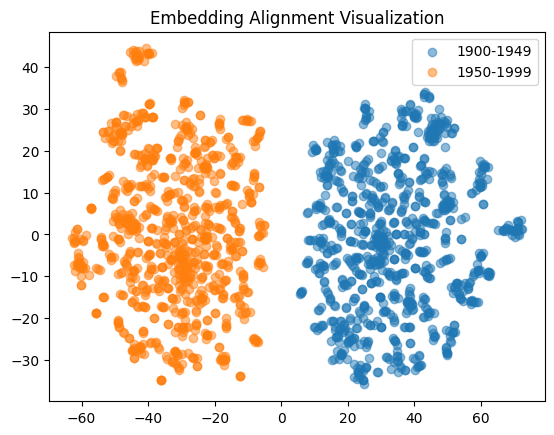

In [421]:
total_len = len(vocab)

# TSNE
combined_matrix = np.vstack([matrix_1800_1850_normalized, aligned_matrix_1950_1999_normalized])
reduced_matrix = TSNE(n_components=2).fit_transform(combined_matrix)

# Plot
plt.scatter(reduced_matrix[:total_len, 0], reduced_matrix[:total_len, 1], label='1900-1959', alpha=0.5)
plt.scatter(reduced_matrix[total_len:, 0], reduced_matrix[total_len:, 1], label='1980-1999', alpha=0.5)
plt.legend()
plt.title("Embedding Alignment Visualization")
plt.show()


In [422]:
# Compute word frequency by checking for inclusion in n-grams
word_frequency = [
    filtered_data[filtered_data['lemmatized_ngram'].str.contains(rf'\b{word}\b', regex=True)]['match_count'].sum()
    for word in vocab
]

# Log-transform the frequencies to handle wide ranges
log_frequency = np.log1p(word_frequency)  


print("Sample frequencies:", word_frequency[:10])
print("Sample log frequencies:", log_frequency[:10])

# Displacement values
word_displacement = [displacement[word] for word in vocab]

# Check for valid data
if len(word_displacement) != len(log_frequency):
    print("Mismatch in data lengths. Check vocab and frequency computation.")
else:
    # Perform OLS regression
    X = sm.add_constant(log_frequency)  # Add constant for intercept
    model = sm.OLS(word_displacement, X).fit()

    print(model.summary())

Sample frequencies: [3160, 3030, 356, 877, 4049, 1051, 10419, 176, 158, 1955]
Sample log frequencies: [8.05864371 8.01664788 5.87773578 6.77764659 8.30647216 6.95844839
 9.25148232 5.17614973 5.0689042  7.57865685]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1734
Date:                Fri, 03 Jan 2025   Prob (F-statistic):              0.677
Time:                        17:34:03   Log-Likelihood:                 1467.3
No. Observations:                 932   AIC:                            -2931.
Df Residuals:                     930   BIC:                            -2921.
Df Model:                           1                                         
Covariance Type:            nonrobust                                     

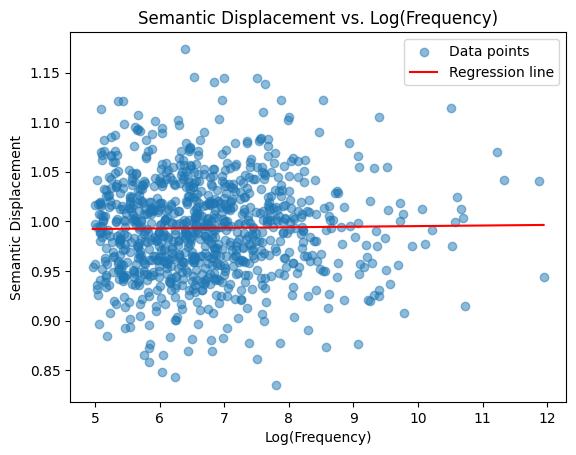

In [423]:
# Scatter plot
plt.scatter(log_frequency, word_displacement, alpha=0.5, label="Data points")
plt.xlabel("Log(Frequency)")
plt.ylabel("Semantic Displacement")
plt.title("Semantic Displacement vs. Log(Frequency)")

slope = model.params[1]
intercept = model.params[0]
x_vals = np.linspace(min(log_frequency), max(log_frequency), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label="Regression line")

plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.009934
Date:                Fri, 03 Jan 2025   Prob (F-statistic):              0.921
Time:                        17:34:23   Log-Likelihood:                 1467.3
No. Observations:                 932   AIC:                            -2931.
Df Residuals:                     930   BIC:                            -2921.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9930      0.003    290.963      0.0

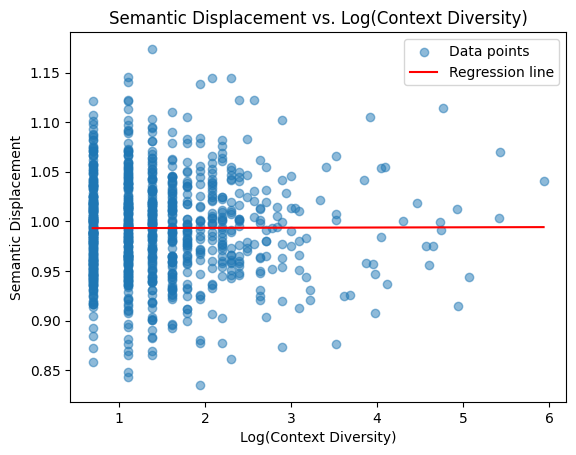

In [424]:
# Compute context diversity (polysemy approximation)
context_diversity = [
    filtered_data[filtered_data['lemmatized_ngram'].str.contains(rf'\b{word}\b', regex=True)]['lemmatized_ngram'].nunique()
    for word in vocab
]

# Prepare data for regression
log_context_diversity = np.log1p(context_diversity)  # Log-transform for scaling
word_displacement = [displacement[word] for word in vocab]

# Regression: Semantic Displacement vs. Log(Context Diversity)
X_polysemy = sm.add_constant(log_context_diversity)  # Add constant for intercept
model_polysemy = sm.OLS(word_displacement, X_polysemy).fit()

# Regression results
print(model_polysemy.summary())

# Visualize relationship between Log(Context Diversity) and Semantic Displacement

# Scatter plot
plt.scatter(log_context_diversity, word_displacement, alpha=0.5, label="Data points")
plt.xlabel("Log(Context Diversity)")
plt.ylabel("Semantic Displacement")
plt.title("Semantic Displacement vs. Log(Context Diversity)")

slope = model_polysemy.params[1]
intercept = model_polysemy.params[0]
x_vals = np.linspace(min(log_context_diversity), max(log_context_diversity), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label="Regression line")

plt.legend()
plt.show()
